In [1]:
include("../scripts/robot.jl")

In [23]:
using Distributions
using LinearAlgebra
using StatsBase

In [44]:
sample([1,2],Weights([1,1]),3)

3-element Array{Int64,1}:
 1
 2
 2

In [33]:
mutable struct Particle
    pose
    weight
end

In [34]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [35]:
function observation_update(self::Particle, observation, envmap, distance_dev_rate, direction_dev)
#     print(observation)
    for d in observation
        obs_pos = d[1]
        obs_id = d[2]+1#1-indexed in julia
        
        pos_on_map = envmap.landmarks[obs_id].pos
        particle_suggest_pos = relative_polar_pos(IdealCamera(), self.pose, pos_on_map)
        
        distance_dev = distance_dev_rate*particle_suggest_pos[1]
        cov = Diagonal([distance_dev^2, direction_dev^2])
        self.weight *= pdf(MvNormal(particle_suggest_pos, cov), obs_pos)
    end
end

observation_update (generic function with 1 method)

In [36]:
mutable struct Mcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
end

In [37]:
function Mcl_(envmap, init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
                        distance_dev_rate=0.14, direction_dev=0.05)
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose, 1.0/num) for i in 1:num-1]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    return self
end

Mcl_ (generic function with 4 methods)

In [38]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [40]:
function observation_update(self::Mcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    resampling(self)
end

observation_update (generic function with 2 methods)

In [45]:
function resampling(self::Mcl)
    ws = [e.weight for e in self.particles]
    if sum(ws) < 1e-100
        ws = [e+1e-100 for e in ws]
    end
    ps = sample(self.particles, Weights(ws), length(self.particles))
    self.particles = [deepcopy(e) for e in ps]
    for p in self.particles
        p.weight = 1.0/length(self.particles)
    end
end

resampling (generic function with 1 method)

In [46]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
end

draw (generic function with 6 methods)

In [47]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [48]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [49]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator,observation)
    return self.nu, self.omega
end

decision (generic function with 4 methods)

In [50]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
end

draw (generic function with 7 methods)

In [51]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    estimator = Mcl_(m, initial_pose, 100)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAlyJtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGbJliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbm+W30NHSaaMM1dbE5zEbpbwjsncqfht2I4QYYjfiMRTv6BmcaAH5k0VRN3NtwqhEG73Dk9wmtmQHtoF+ClM8g8y7ht88V/ldHEWCP7gOz37X4C7QiAs0+JJ4G9ONlRw5NqpsSNJprPWDwF1x9JZIhOI83dHTalxamF/fjzpP8c7yK6Pdn2+zkAnMxGqdsKanpf3K1jKiHAmEngRwl9OJDPTTqPHekzPhq87FTYo+/RpBHzVELi+AaicbRZtPuRhXy9AdAFx6a1eFgqxSnjE6339xx0cNWHrsqzKRmTZ+X6MBCLc4J3HlKK3LIWHsmlWGjKOTaZcyornok72lqXPwFEXRFDbaC8IHthoFevghyWvz1YWBvLR19ZB/NTb/+EItbU11ASKDssDNRSzo7ulG9Nzfx1JT3bwEyiD4cKiW+r4Nos6mN2Nd3uYsx6j6Ii9AdKH3NYEiNtUiFezA/gCbZNOsjCT/07hLv+G4W1UAZSZJMt7CMnXa+E5nLFGSjbyDV4PYz7DD/aRvpJgLp9gADvelGeqHBiWjNgGKf2irRHH0KYmIvovlpjs/rB+5bh2xOGn9+g4+L9WzAt/xyKt0Om145ZsRbdV7plg13/JctNZcf+anZUH+rv0foDE29/n6zbfjvj81yD78nxKStOjxa+FtYRiuVb/VItyFXmaAQDOoPghDVXB7RZtD8KDzz7EwiYsZ1aCUVM6dPDA4SXbTPhopP3UwAD/NTy+DDg4lYjvMfBskRpNK3s2+wLviB/NjfMWgybPmuI3ezcGz9UJz89XjDob2hkWOk82ygiaSUHHGV9M87rewsK0dOkO/JtdOC1lGECG2APSkKJSbsI73aFszntcC5Mmf59VNAof48jxV8fYoReHYOclDvjrKcuwMw2nBRPDDbX3XZjchjP8UR3+jntxEekcLA0/c12mjIomK+HAD6u4XA8ZBDEuVLDLXksLxGIDQkqCajJ55jVGpACjimOlXloHtUCXga7djZldTSm6sDswoiGH9e3GbOeP490WK2XphDH/qn7N14P2Inrq+viYvz927vqt+bJeIlBbJ0jijtRc3M7ZWSbsY8WrLk+esVQIf6Oq+4FnwP3gape27iI3Ufq2Asqd3FM62Azv6N/eooXYNogWeWPh7pQKHt+M+C6Pnd1rJ62KVmr8NBTFELwaLHBPkh43yj/7sdCyrZTE1HiaMuW12os+oRgv0/7HbqCCXBvOQwZ7PSA+z5KNGhidxjkvvJNnkAUb8Mf6ev+UANsyR3C7pCYMx6do0cglnjrUpVYy11z6if29OGypXCMM5zfumdSROTx/xQNg7T9Fst7TjUPznxb+M9z9MKAu9NKkuwHrQi+642mS+7AXt0rX8GCBALX6Z/i6E/9y+jLLijmpWMfe/2UxJzjGvj06QOGFQ4UQXeXzTDopaz/IVwqARjmY2njRCqChwGLDIYoz5qOVSYfCvCmEmVrI3z8r7F572tKCdXZdm4Iyl9fhPUznJMxFNsskgi6rlILx+I09EIxXIQlAoxHX6zB/lN3b3Geun+5hZPEiG4HqvhUMMK5TWX8/KpS/6MiQP+GcMRXx8kboh5KUmvhiZXy+gIliabUOq/yh6GLTSdGuGlcz/07kvfLXeqDfK1n5mh/aa+31pWtOkexYaajOXd6OcDKb9Ya2JtHPv9/J4G+iIrGO5LRAwe/AujOk/ZL8Y46UR6fd8ui4nduCW7QTnNQrXc71vGhuHDaL9cGncH0voaxZom5nYcWLPvnf/YPTmgziWh7gCJd5awYLSmOPw28q3456vivRg9yEXI6mNDa/fvay8k7w75yEW68E/m65o2ODatljkWKZP3GoQIpnwRqZVGxS8e2T2PwJcmmqMZMs8n6qMktKklA2oayHZm5fKmZIjs6hVE6TzanywrP/0wu57UmK+JCNtj7oL/pACIbjmnooqWKIb6VpSnsQor0LlUBA9DVa8oFmPxKOKMCXHo9VB2qDr2s/yJKQE7Ul/HeHuD59Oh7DvbVEplZxnt2k9F5HznKwS8fUokxyDp8cUjY3Z1hji8T+Kgrj5rmSco7PtKAcWIDxS2GaSHyh0xAlSBqNl8K28jxtnZTgApvBg1VxsuWkpJW0esBbYabIDiNt7C/WSMxDVy9w3nOWfqkmsFfEgMOfzCK9Te4F56+WgbbVDKZAm6lOKM6M6yTzGqLS++ISFsW0ryKGpRIVjeTehEBXKYYWgefPi3mLWN4DXtDRg7sauJN/vFY42QuJrtT/EXuKz/IboNT2YzTw5X/zNPSqQum1vdhPDrKf39f0Moo6VZS6KHWigy0hKCQvy6Pcn6e0i7iry+Pzo3r/Xzenl+He7J170EACGy/PX4+FzB/UKZmzIjNQOD03uMkgHR2J1nX2JWHnqRkW2JYblBL+aNPraNoyS06nxPd5duHrJvHfWxGn3wtm+6iW8A0yt5MGpA/NbnCrI2mkWn24EnI+atMpE0UoP+3UggGNNa6ijrwaukFdQqvIfWh6NZLF55FjMRHNrKEq8iOr5orHUetmv4Fnb4IrnKCE3qgVZFp5UmlTbSO6eOx5P7+kd1+yEDd1Ch

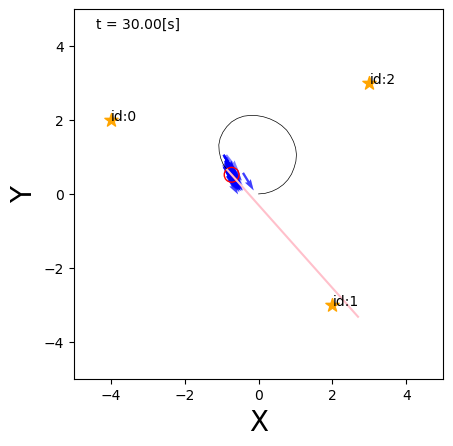

In [52]:
trial()